In [30]:
import ACTDR
import matplotlib.pyplot as plt
import ios_ctd
import os
import pickle
import numpy as np
import seawater as SW
import TSmode
import seaborn as sns


%matplotlib inline

In [31]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('poster')

In [2]:
def conv_ios_dat_to_standard(dat):
    ret_dat = {}
    
    KEEP_VARS = {'Pressure' : 'Pressure', 'Temperature:Primary' : 'Temperature', 'Salinity:T0:C0' : 'Salinity', 'Oxygen:Voltage:SBE' : 'Oxygen'}
    
    ret_dat['STATION'] = dat['STATION']
    ret_dat['Longitude'] = dat['Longitude']
    ret_dat['Latitude'] = dat['Latitude']
    
    for cnt,ii in enumerate(dat['Variables']):
        if ii['Name'] in KEEP_VARS:
            ret_dat[KEEP_VARS[ii['Name']]] = dat['DATA'][cnt]
    
    ret_dat['Depth'] = SW.dpth(ret_dat['Pressure'],ret_dat['Latitude'])
    
    ret_dat['sigmaT'] = SW.dens(ret_dat['Salinity'],ret_dat['Temperature'],ret_dat['Pressure'])-1000
    inds = ~np.isnan(ret_dat['sigmaT'])
    ret_dat['sigmaT'] = np.interp(np.arange(0,len(ret_dat['sigmaT'])),np.arange(0,len(ret_dat['sigmaT']))[inds],ret_dat['sigmaT'][inds])
    
    ret_dat['Year'] = 2013
    ret_dat['Month'] = 8
    
    return ret_dat

In [3]:
falk_dat = []

filenames = ['/ocean/rirwin/2_FALKOR_Data/7_Falkor_CTD/'+f for f in os.listdir('/ocean/rirwin/2_FALKOR_Data/7_Falkor_CTD/') if (f.endswith('ctd') or f.endswith('CTD') or f.endswith('avg'))]

for f in filenames:
    falk_dat.append(conv_ios_dat_to_standard(ios_ctd.ios_read(f)))
    
wcvi_top = pickle.load(open('topo.p','rb'))

/home/rirwin/anaconda/lib/python2.7/site-packages/seawater/eos80.py:450: RuntimeWarning: invalid value encountered in sqrt
  s ** 0.5 + d * s ** 2)
/home/rirwin/anaconda/lib/python2.7/site-packages/seawater/library.py:338: RuntimeWarning: invalid value encountered in sqrt
  A = AW + (i[0] + (i[1] + i[2] * T68) * T68 + j0 * s ** 0.5) * s
/home/rirwin/anaconda/lib/python2.7/site-packages/seawater/library.py:346: RuntimeWarning: invalid value encountered in sqrt
  (g[0] + (g[1] + g[2] * T68) * T68) * s ** 0.5) * s)  # Eqn 16.


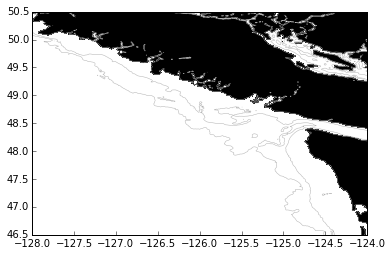

In [42]:
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-100,0],colors=[0.7,0.7,0.7],linewidths=0.5)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim((-128,-124))
plt.ylim((46.5,50.5))
plt.show()

In [4]:
def get_vals_at_sigmaT_surf(cast,sigT):
    vals = {'Depth' : np.nan, 'Salinity' : np.nan, 'Temperature' : np.nan, 'Oxygen' : np.nan}
    
    if np.min(cast['sigmaT']) > sigT or np.max(cast['sigmaT']) < sigT:
        return vals
    
    for ii in range(0,len(cast['Depth'])):
        if cast['sigmaT'][ii] > sigT:
            vals['Depth'] = cast['Depth'][ii]
            vals['Salinity'] = cast['Salinity'][ii]
            vals['Temperature'] = cast['Temperature'][ii]
            vals['Oxygen'] = cast['Oxygen'][ii]
            return vals

In [5]:
sig_vals = []

for ii in falk_dat:
    val = get_vals_at_sigmaT_surf(ii,25.5)
    sig_vals.append(val)

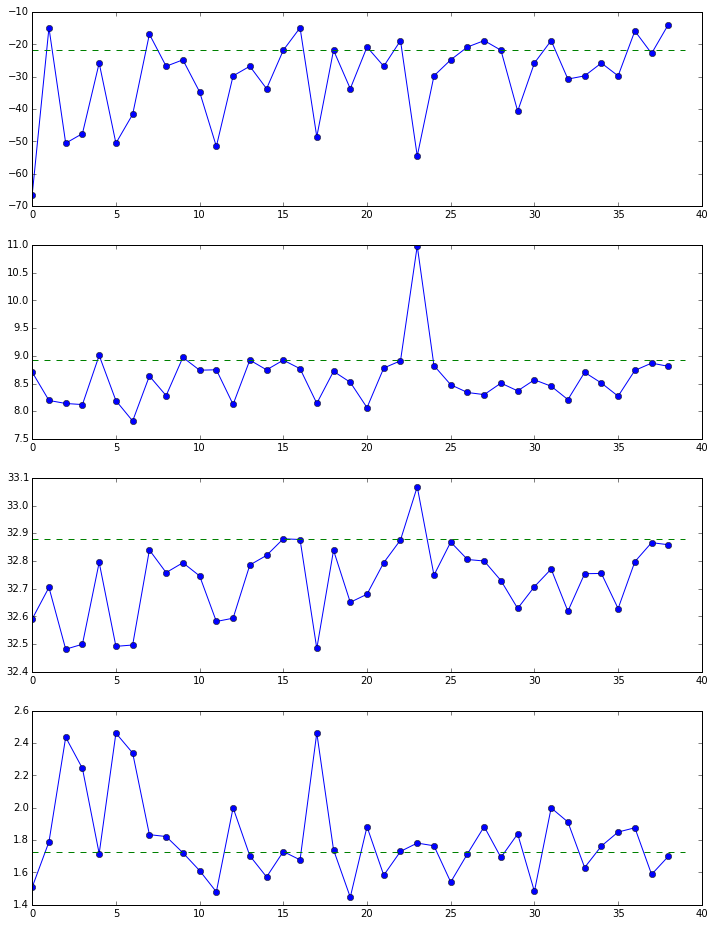

In [6]:
MB07 = get_vals_at_sigmaT_surf([k for k in falk_dat if k['STATION'] == 'MB07'][0],25.5)

plt.figure(figsize=(12,16))

plt.subplot(4,1,1)
plt.plot([-k['Depth'] for k in sig_vals],'-o')
plt.plot([0,39],[-MB07['Depth'],-MB07['Depth']],'--')

plt.subplot(4,1,2)
plt.plot([k['Temperature'] for k in sig_vals],'-o')
plt.plot([0,39],[MB07['Temperature'],MB07['Temperature']],'--')

plt.subplot(4,1,3)
plt.plot([k['Salinity'] for k in sig_vals],'-o')
plt.plot([0,39],[MB07['Salinity'],MB07['Salinity']],'--')

plt.subplot(4,1,4)
plt.plot([k['Oxygen'] for k in sig_vals],'-o')
plt.plot([0,39],[MB07['Oxygen'],MB07['Oxygen']],'--')

LC07
RD04
BCC5
LB08
BCC4
MB07
NN03
BCC3
NN02
LC05-A
TC01
BCC2
LC06


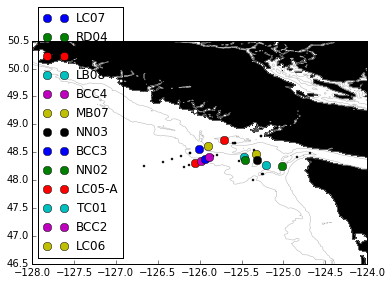

In [7]:
match_inds = []

for cnt,ii in enumerate(sig_vals):
    Seps = 0.2
    Teps = 0.2
    if np.abs(ii['Salinity']-MB07['Salinity']) < Seps and np.abs(ii['Temperature']-MB07['Temperature']) < Teps:
        match_inds.append(cnt)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)
        
for ii in match_inds:
    print falk_dat[ii]['STATION']
    plt.plot(falk_dat[ii]['Longitude'],falk_dat[ii]['Latitude'],'o',ms=8,label=falk_dat[ii]['STATION'])
    
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-100,0],colors=[0.7,0.7,0.7],linewidths=0.5)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim((-128,-124))
plt.ylim((46.5,50.5))
plt.legend(loc=3)
plt.show()

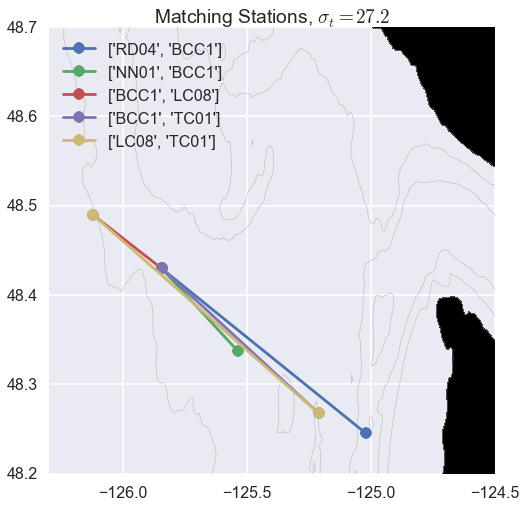

In [37]:
sigT = 27.2

plt.figure(figsize=(8,8))

MB07 = get_vals_at_sigmaT_surf([k for k in falk_dat if k['STATION'] == 'MB07'][0],27.2)

match_pairs = []

for cnt,ii in enumerate(falk_dat[:-1]):
    for cnt2,jj in enumerate(falk_dat[cnt+1:]):
        if ii['STATION'] == jj['STATION']:
            continue
        stats = [ii['STATION'],jj['STATION']]
        if 'LB08' in stats or 'MB07' in stats or 'NN02' in stats or 'MB08' in stats:
            continue
            
        sv1 = get_vals_at_sigmaT_surf(ii,sigT)
        sv2 = get_vals_at_sigmaT_surf(jj,sigT)
        
        mndpth = np.mean([sv1['Depth'],sv2['Depth']])
        mntemp = np.mean([sv1['Temperature'],sv2['Temperature']])
        mnsaln = np.mean([sv1['Salinity'],sv2['Salinity']])
        mnoxyg = np.mean([sv1['Oxygen'],sv2['Oxygen']])
        
        dpth_eps = 10
        temp_eps = 0.2
        saln_eps = 0.1
        oxyg_eps = 0.1
        
        #if np.abs(mndpth-MB07['Depth']) < dpth_eps and \
        if np.abs(mntemp-MB07['Temperature']) < temp_eps and \
            np.abs(mnsaln-MB07['Salinity']) < saln_eps:# and \
            #np.abs(mnoxyg-MB07['Oxygen']) < oxyg_eps:
            match_pairs.append([ii,jj])
            
for ii in match_pairs:
    plt.plot([k['Longitude'] for k in ii],[k['Latitude'] for k in ii],'-o',label=[k['STATION'] for k in ii])

plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-200,-100,0],colors=[0.7,0.7,0.7],linewidths=0.5)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim((-126.3,-124.5))
plt.ylim((48.2,48.7))
plt.legend(loc=2)

plt.title(r'Matching Stations, $\sigma_t = 27.2$')

plt.show()

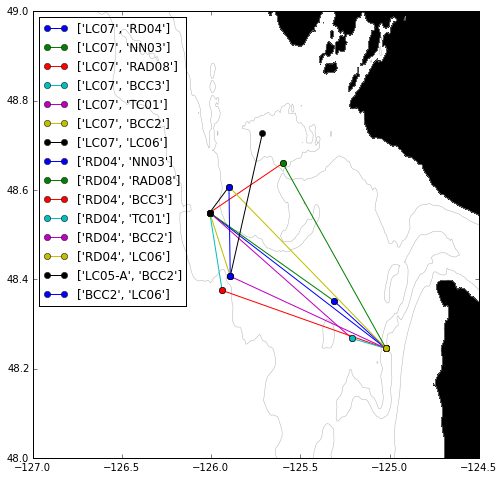

In [9]:
sigT = 25.5

plt.figure(figsize=(8,8))

MB07 = get_vals_at_sigmaT_surf([k for k in falk_dat if k['STATION'] == 'MB07'][0],sigT)

match_pairs = []

for cnt,ii in enumerate(falk_dat[:-1]):
    for cnt2,jj in enumerate(falk_dat[cnt+1:]):
        if ii['STATION'] == jj['STATION']:
            continue
        stats = [ii['STATION'],jj['STATION']]
        if 'LB08' in stats or 'MB07' in stats or 'NN02' in stats or 'MB08' in stats:
            continue
            
        sv1 = get_vals_at_sigmaT_surf(ii,sigT)
        sv2 = get_vals_at_sigmaT_surf(jj,sigT)
        
        mndpth = np.mean([sv1['Depth'],sv2['Depth']])
        mntemp = np.mean([sv1['Temperature'],sv2['Temperature']])
        mnsaln = np.mean([sv1['Salinity'],sv2['Salinity']])
        mnoxyg = np.mean([sv1['Oxygen'],sv2['Oxygen']])
        
        dpth_eps = 5
        temp_eps = 0.1
        saln_eps = 0.1
        oxyg_eps = 0.1
        
        if np.abs(mndpth-MB07['Depth']) < dpth_eps and \
            np.abs(mntemp-MB07['Temperature']) < temp_eps and \
            np.abs(mnsaln-MB07['Salinity']) < saln_eps and \
            np.abs(mnoxyg-MB07['Oxygen']) < oxyg_eps:
            match_pairs.append([ii,jj])
            
for ii in match_pairs:
    plt.plot([k['Longitude'] for k in ii],[k['Latitude'] for k in ii],'-o',label=[k['STATION'] for k in ii])

plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-100,0],colors=[0.7,0.7,0.7],linewidths=0.5)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim((-127,-124.5))
plt.ylim((48,49))
plt.legend(loc=2)
    
plt.show()

In [10]:
LONrng=[-127,-124.5]
LATrng=[48,48.8]


> using  33  cast data


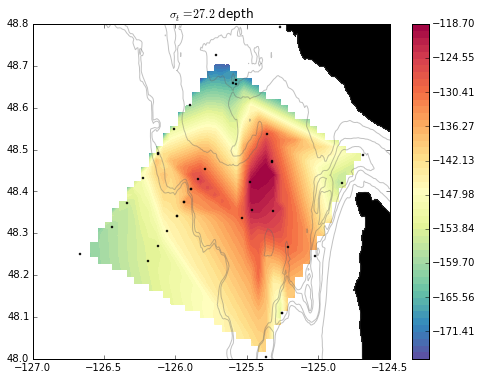

In [26]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.2,'Depth',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,-grid_dat,levels=np.linspace(np.nanmin(-grid_dat),np.nanmax(-grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=27.2$ depth')

plt.show()

> using  37  cast data


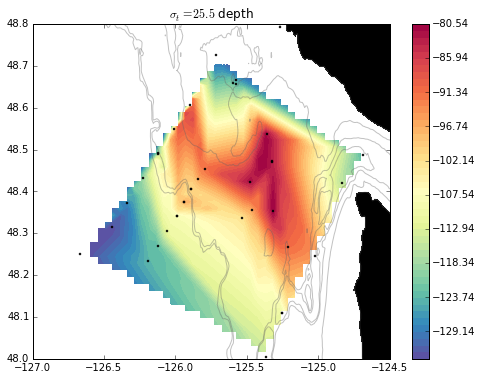

In [25]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,26.94,'Depth',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,-grid_dat,levels=np.linspace(np.nanmin(-grid_dat),np.nanmax(-grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=25.5$ depth')

plt.show()

> using  33  cast data


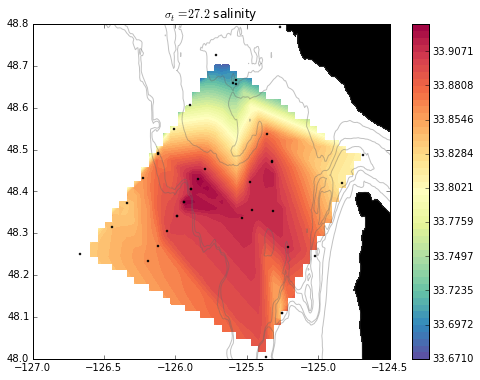

In [24]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.2,'Salinity',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,grid_dat,levels=np.linspace(np.nanmin(grid_dat),np.nanmax(grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=27.2$ salinity')

plt.show()

> using  39  cast data


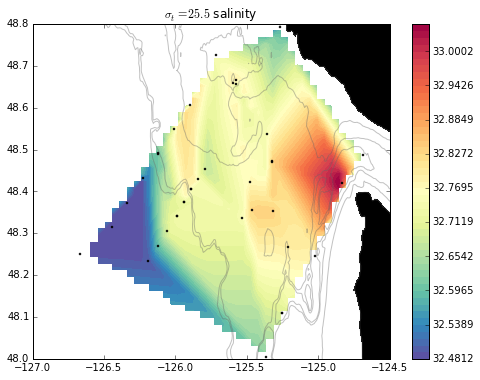

In [23]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,25.5,'Salinity',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,grid_dat,levels=np.linspace(np.nanmin(grid_dat),np.nanmax(grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=25.5$ salinity')

plt.show()

> using  33  cast data


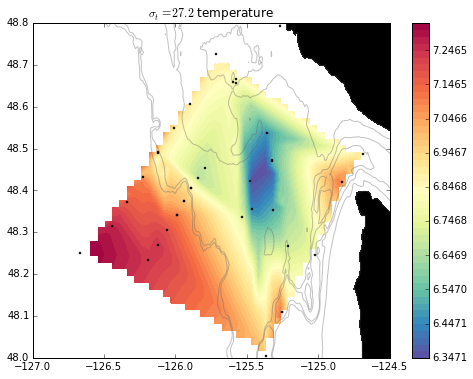

In [22]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.2,'Temperature',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,grid_dat,levels=np.linspace(np.nanmin(grid_dat),np.nanmax(grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=27.2$ temperature')

plt.show()

> using  21  cast data


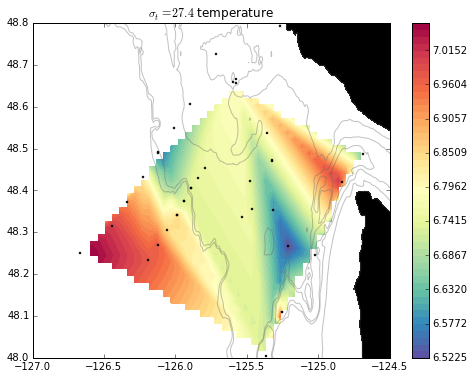

In [18]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.4,'Temperature',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,grid_dat,levels=np.linspace(np.nanmin(grid_dat),np.nanmax(grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=27.4$ temperature')

plt.show()

> using  21  cast data


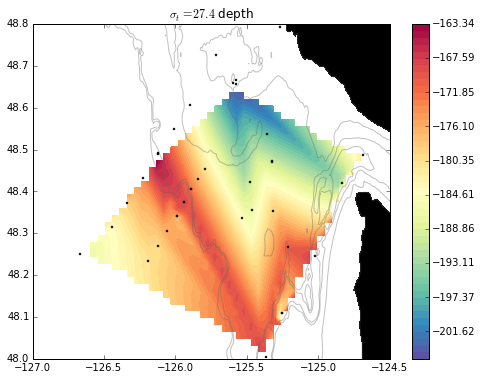

In [21]:
plt.figure(figsize=(8,6))
(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.4,'Depth',LONrng,LATrng)

plt.plot([k['Longitude'] for k in falk_dat],[k['Latitude'] for k in falk_dat],'.k',ms=4)

im=plt.contourf(lon_region,lat_region,-grid_dat,levels=np.linspace(np.nanmin(-grid_dat),np.nanmax(-grid_dat),50),cmap='Spectral_r')
plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-250,-200,-100,0],colors=[0.4,0.4,0.4],linewidths=1)
plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=1)

plt.xlim(LONrng)
plt.ylim(LATrng)

plt.colorbar(im)

plt.title(r'$\sigma_t=27.4$ depth')

plt.show()

In [172]:
from mpl_toolkits.mplot3d import Axes3D

> using  33  cast data
> using  39  cast data


/home/rirwin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/rirwin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


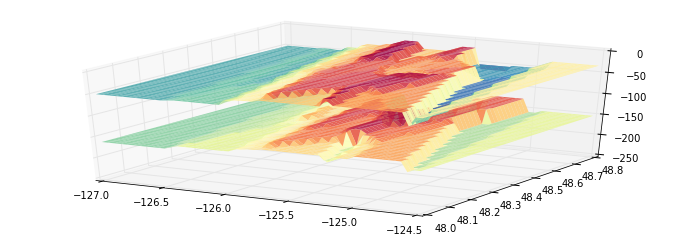

In [250]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111, projection='3d')

flat_top = wcvi_top
flat_top['topo'][flat_top['topo']>0] = 0
flat_top['topo'][flat_top['topo']<-250] = np.nan
flat_top['topo'][flat_top['lons']>LONrng[1]] = np.nan
flat_top['topo'][flat_top['lons']<LONrng[0]] = np.nan
flat_top['topo'][flat_top['lats']>LATrng[1]] = np.nan
flat_top['topo'][flat_top['lats']<LATrng[0]] = np.nan


#tsurf = ax.plot_surface(flat_top['lons'],flat_top['lats'],flat_top['topo'], rstride=10, cstride=10, shade=True, cmap='gist_earth', linewidth=0, antialiased=False, vmin=-250, vmax=0)
#tsurf = ax.plot_wireframe(flat_top['lons'],flat_top['lats'],flat_top['topo'], rstride=10, cstride=10, color='k')

(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,27.2,'Depth',LONrng,LATrng)
isopyc1 = ax.plot_surface(lon_region,lat_region,-grid_dat,cmap='Spectral_r',shade=True,linewidth=0,rstride=1,cstride=1)
isopyc1.set_alpha(0.9)

(lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(falk_dat,25.5,'Depth',LONrng,LATrng)
isopyc2 = ax.plot_surface(lon_region,lat_region,-grid_dat,cmap='Spectral_r',shade=True,linewidth=0,rstride=1,cstride=1)
isopyc2.set_alpha(0.9)

#ax.view_init(elev=30., azim=-135)
ax.autoscale_view()

ax.set_xlim3d(LONrng)
ax.set_ylim3d(LATrng)
ax.set_zlim3d((-250,0))

plt.show()